<a href="https://colab.research.google.com/github/AadeshVarude/PB_lite_edge_detection/blob/main/pblite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RBE/CS549 Fall 2022: Computer Vision
## Homework 0: Alohomora

Author(s): 
Prof. Nitin J. Sanket (nsanket@wpi.edu), Lening Li (lli4@wpi.edu), Gejji, Vaishnavi Vivek (vgejji@wpi.edu)

Robotics Engineering Department,

Worcester Polytechnic Institute

Code adapted from CMSC733 at the University of Maryland, College Park.


## Phase 1




### Get the BSDS500 dataset

In [ ]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/BSDS500.tar.xz
!tar -xvf BSDS500.tar.xz
!mv BSDS500/ /content/data/

--2022-08-23 13:54:14--  https://raw.githubusercontent.com/leelening/rbe549/main/hw0/BSDS500.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 812060 (793K) [application/octet-stream]
Saving to: ‘BSDS500.tar.xz’

BSDS500.tar.xz      100%[===================>] 793.03K  --.-KB/s    in 0.01s   

2022-08-23 13:54:14 (72.1 MB/s) - ‘BSDS500.tar.xz’ saved [812060/812060]

BSDS500/
BSDS500/CannyBaseline/
BSDS500/CannyBaseline/1.png
BSDS500/CannyBaseline/10.png
BSDS500/CannyBaseline/2.png
BSDS500/CannyBaseline/3.png
BSDS500/CannyBaseline/4.png
BSDS500/CannyBaseline/5.png
BSDS500/CannyBaseline/6.png
BSDS500/CannyBaseline/7.png
BSDS500/CannyBaseline/8.png
BSDS500/CannyBaseline/9.png
BSDS500/GroundTruth/
BSDS500/GroundTruth/1.png
BSDS500/GroundTruth/10.png
BSDS500/

In [ ]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/TxtFiles.tar.xz
!tar -xvf TxtFiles.tar.xz
!mv TxtFiles/ /content/data/

--2022-08-23 13:54:14--  https://raw.githubusercontent.com/leelening/rbe549/main/hw0/TxtFiles.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55376 (54K) [application/octet-stream]
Saving to: ‘TxtFiles.tar.xz’

TxtFiles.tar.xz     100%[===================>]  54.08K  --.-KB/s    in 0.001s  

2022-08-23 13:54:14 (43.0 MB/s) - ‘TxtFiles.tar.xz’ saved [55376/55376]

TxtFiles/
TxtFiles/DirNamesTest.txt
TxtFiles/DirNamesTrain.txt
TxtFiles/LabelsTest.txt
TxtFiles/LabelsTrain.txt


array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4])

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
from matplotlib.pyplot import imshow
import math
import imutils
import os
import sklearn.cluster
import os

1. Generate Difference of Gaussian Filter Bank: (DoG)
2. Display all the filters in this filter bank and save image as DoG.png,
3. use command "cv2.imwrite(...)"

In [ ]:
Filter_bank=[]

In [ ]:
def derivative_calculation_func(sigma, mu, x, ord):
    x = np.array(x)  #converting the x into a numpy array;
    x_m = x - mu
    var = sigma**2

    # Implementing the gaussian function formula
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_m*x_m)/(2*var)))
    if ord == 0:
        g = g1
        return g
    else :
        g = -g1*((x_m)/(var))
        return g

In [ ]:
def creating_filter_img_DOG(scale, phasex, phasey, pts, sup):

    gx = derivative_calculation_func(scale, 0, pts[0,...], phasex)
    gy = derivative_calculation_func(scale,   0, pts[1,...], phasey)

    image = gx*gy

    image = np.reshape(image,(sup,sup))
    return image

In [ ]:
def DOG():
    size     = 49
    scale  = np.array([1,2])
    norient = 16
    h  = (size - 1)/2
    filter_store_dog=[]

    x = [np.arange(-h,h+1,1)]
    y = [np.arange(-h,h+1,1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)
    
    for s in range(len(scale)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            cos = np.cos(angle)
            sin = np.sin(angle)
            rotation_matrix = [[cos+0,-sin+0],[sin+0,cos+0]]
            rotation_matrix = np.array(rotation_matrix)
            rotation_matrix = np.dot(rotation_matrix,orgpts)
            filter = creating_filter_img_DOG(scale[s], 0, 1, rotation_matrix, size)
            filter_store_dog.append(filter)
                
    return filter_store_dog

In [ ]:
DOGF = DOG()


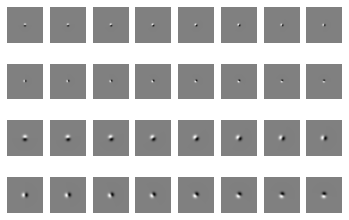

In [ ]:
for i in range(0,32):
  plt.subplot(4,8,i+1)
  plt.axis('off')
  plt.imshow(DOGF[i], cmap = 'gray')


1. Generate Leung-Malik Filter Bank: (LM)
2. Display all the filters in this filter bank and save image as LM.png,
3. use command "cv2.imwrite(...)"


In [ ]:
def der_o_1dgauss(sigma, mu, x, ord):
    x = np.array(x)  #converting the x into a numpy array;
    x_m = x - mu
    var = sigma**2

    # Implementing the gaussian function formula
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_m*x_m)/(2*var)))
    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x_m)/(var))
        return g
    else:
        g = g1*(((x_m*x_m) - var)/(var**2))
        return g


In [ ]:
def gauss2d_with_scales(size, scales):
    shape = (size,size)
    var = scales * scales
    a,b = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-b:b+1,-a:a+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g

In [ ]:
def laplacian_o_gauss2d(size, scales):
    shape = (size,size)
    var = scales * scales
    a,b = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-b:b+1,-a:a+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    log = g*((x*x + y*y) - var)/(var**2)
    return log

In [ ]:
def creating_filter_img(scale, phasex, phasey, pts, sup):

    gx =  der_o_1dgauss(3*scale, 0, pts[0,...], phasex)
    gy =  der_o_1dgauss(scale,   0, pts[1,...], phasey)

    image = gx*gy

    image = np.reshape(image,(sup,sup))
    
    return image

In [ ]:
def LMfilters(scales):
    size = 49
    norient = 6
    nrotinv = 12
    first_der=[]
    second_der=[]
    filter_store=[]
    h= (size - 1)/2

    x = [np.arange(-h,h+1)]
    y = [np.arange(-h,h+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)
  
    for scale in range(len(scales)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            cos = np.cos(angle)
            sin = np.sin(angle)
            rotpts = [[cos+0,-sin+0],[sin+0,cos+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            filter = creating_filter_img(scales[scale], 0, 1, rotpts, size)
            first_der.append(filter)
            filter = creating_filter_img(scales[scale], 0, 2, rotpts, size)
            second_der.append(filter)
            

    filter_store=first_der+second_der
    
    for i in range(len(scales)):
        filter=gauss2d_with_scales(size, scales[i])
        filter_store.append(filter)

        
    for i in range(len(scales)):
        
        filter=laplacian_o_gauss2d(size, scales[i])
        filter_store.append(filter)

        
    for i in range(len(scales)):
        
        filter=laplacian_o_gauss2d(size, 3*scales[i])
        filter_store.append(filter)

        
    return filter_store

In [ ]:
LMS= LMfilters(np.sqrt(2) ** np.array([0,1,2,3]))
n=len(F)
len(F)
LML= LMfilters(np.sqrt(2) ** np.array([1,2,3,4]))


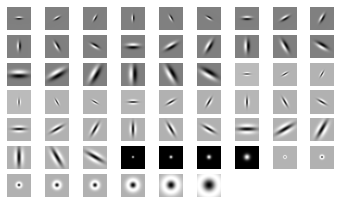

In [ ]:
for i in range(n):
    plt.subplot(8,9,i+1)
    # title(r'$\theta$={theta:.2f}$\omega$={omega}'.format(**gaborParams[i]))
    plt.axis('off'); plt.imshow(LML[i],cmap = 'gray')

1. Generate Gabor Filter Bank: (Gabor)
2. Display all the filters in this filter bank and save image as Gabor.png,
3. use command "cv2.imwrite(...)"


In [ ]:
def gabor_func(size, w, theta):
  #note : the w in this code stands for omega
    m,n =[int(i/2.0) for i in size] # params to create meshgrid
    [x, y] = np.meshgrid(range(-m, m+1), range(-n, n+1))

    x1 = x * np.cos(theta) + y * np.sin(theta)
    y1 = -x * np.sin(theta) + y * np.cos(theta)
    
    # Using the gaussian sinusoidal formula for the gabor generation
    gauss = w**2 / (4*np.pi * np.pi**2) * np.exp(- w**2 / (8*np.pi**2) * ( 4 * x1**2 + y1**2))

    sinusoid = np.sin(w * x1) * np.exp(np.pi**2 / 2)

    gabor = gauss * sinusoid
    return gabor


In [ ]:
#generating a gabor filter bank
def gabor_filter_bank():
  num_rotations=8
  omegas=[0.25,0.2,0.15,0.1,0.05]
  gfb=[]
  for omega in omegas:
    for num_rotation in range(num_rotations):
      theta= num_rotation*np.pi/(num_rotations)
      gabor=gabor_func((128,128),omega,theta)
      gfb.append(gabor)
  
  return gfb



In [ ]:
gfb=gabor_filter_bank()
Filter_bank=DOGF+gfb+LMS+LML

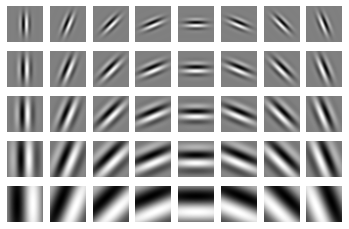

In [ ]:
gfb=gabor_filter_bank()
n=len(gfb)
type(gfb)
for i in range(n):
    plt.subplot(5,8,i+1)
    # title(r'$\theta$={theta:.2f}$\omega$={omega}'.format(**gaborParams[i]))
    plt.axis('off'); plt.imshow(gfb[i],cmap='gray')

1. Generate Half-disk masks
2. Display all the Half-disk masks and save image as HDMasks.png,
3. use command "cv2.imwrite(...)"

In [ ]:
import imutils

In [ ]:
def halfDisk(r, a):
  #r is for the radius and a is for the angle 
	size = 2*r + 1
	centre = r
	half_disk = np.zeros([size, size])
	for x in range(r):
		for y in range(size):
			distance = (x-centre)*(x-centre) + (y-centre)*(y-centre)
			if distance <= r*r:
				half_disk[x,y] = 1
	
	half_disk = imutils.rotate(half_disk, a) # for rotating the created image
	return half_disk
def halfdiskFilters(r_array, num_rotations):
	hd_bank = []
  # hd_bank=np.array(hd_bank)
	for r in r_array:
		hd_pairs = []
		temp = []
		for num_rotation in range(num_rotations):
			a = num_rotation * 360 / num_rotations
			half_disk_filter = halfDisk(r, a)
			temp.append(half_disk_filter)

      #clubbing the exactly opposite ones
		i = 0
		while i < num_rotations/2:
			hd_pairs.append(temp[i])
			hd_pairs.append(temp[i+int((num_rotations)/2)])
			i = i+1
		hd_bank+=hd_pairs
	
	
	return hd_bank

In [ ]:
half_disk_filter_bank = halfdiskFilters([3,6,15,20,30], 16)
half_disk_filter_bank=np.array(half_disk_filter_bank)
type(half_disk_filter_bank)
print(half_disk_filter_bank.shape)

(80,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


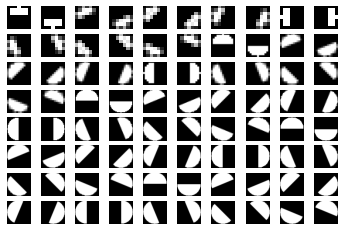

In [ ]:
	for index in range(len(half_disk_filter_bank)):
		plt.subplot(8, 10, index+1)
		plt.axis('off')
		plt.imshow(half_disk_filter_bank[index], cmap='gray')

1. Generate Texton Map
2. Filter image using oriented gaussian filter bank


In [ ]:
import glob

In [ ]:
image_list = []
path=glob.glob("/content/data/Images/*.jpg")

for filename in path:  # assuming gif
    # print("in for")
    im = cv2.imread(filename)
    image_list.append(im)
    # cv2.imshow("img",im)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


0
(321, 481, 3)
1
(321, 481, 3)
2
(321, 481, 3)
3
(321, 481, 3)
4
(321, 481, 3)
5
(321, 481, 3)
6
(321, 481, 3)
7
(321, 481, 3)
8
(321, 481, 3)


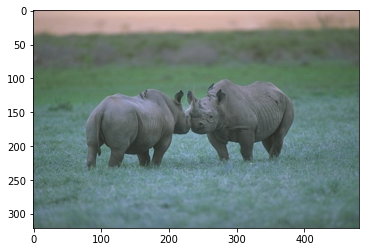

In [ ]:
for i in range(len(image_list)):
  print(i)
  print(image_list[i].shape)
  # plt.imshow
plt.imshow(image_list[1])

In [ ]:
def filtering_image(img, filter_bank):
  filtered_img=[]
  for filter in filter_bank:
    gray_img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    output=cv2.filter2D(gray_img,-1,filter)
    filtered_img.append(output)
  return filtered_img



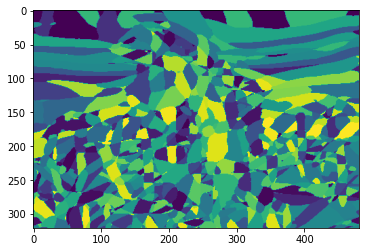

In [ ]:
plt.imshow(texton)

In [ ]:
image=cv2.imread("/content/data/Images/7.jpg")
image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
x,y=image.shape
matrix=image.reshape([x*y,1])
#applying the clustering
#bins used here are 64 as suggested
k_m= sklearn.cluster.KMeans(n_clusters = 16, n_init = 5).fit(matrix)
label=k_m.predict(matrix)
brightness_img=label.reshape([x,y])
# b_maps.append(brightness_img)

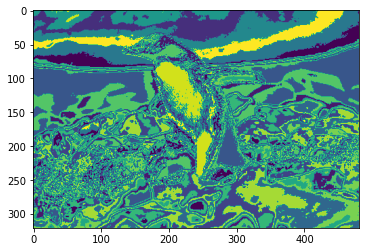

In [ ]:
plt.imshow(brightness_img)

In [ ]:
image=cv2.imread("/content/data/Images/2.jpg")
# image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
x,y,s=image.shape
matrix=image.reshape([x*y,s])
#applying the clustering
#bins used here are 64 as suggested
k_m= sklearn.cluster.KMeans(n_clusters = 16, n_init = 5).fit(matrix)
label=k_m.predict(matrix)
colour_img=label.reshape([x,y])
# c_maps.append(colour_img)
#printing the texton maps

(321, 481)
(321, 481)


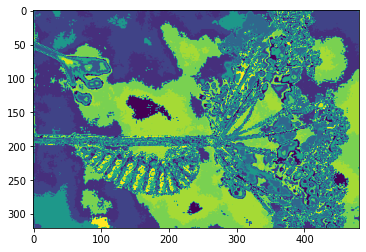

In [ ]:
plt.imshow(colour_img)
print(colour_img.shape)
T_c=chi_sqr_dist(colour_img,64,half_disk_filter_bank)
T_c=np.array(T_c)
T_c=np.mean(T_c,axis=0)
print(T_c.shape)

In [ ]:
# img= cv2.imread("/content/drive/MyDrive/Phase1/BSDS500/Images/1.jpg")
# gray_img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# output=cv2.filter2D(gray_img,-1,gfb[0])
# imshow(output)

In [ ]:
# Images=Load(image_folder,files)
# Generating a texton map 

textonmap=[]
for i, image in enumerate(image_list):
  filtered_image=filtering_image(image,Filter_bank)
  filtered_image=np.array(filtered_image)
  # If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.
  feat,x,y=filtered_image.shape
  matrix=filtered_image.reshape([feat,x*y])
  matrix=matrix.transpose()
  #applying the clustering
  #bins used here are 64 as suggested
  k_m= sklearn.cluster.KMeans(n_clusters = 64, n_init = 2).fit(matrix)
  label=k_m.predict(matrix)
  texton=label.reshape([x,y])
  textonmap.append(texton)
  #printing the texton maps


In [ ]:
b_maps=[]
for i, image in enumerate(image_list):
  image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  x,y=image.shape
  matrix=image.reshape([x*y,1])
  #applying the clustering
  #bins used here are 64 as suggested
  k_m= sklearn.cluster.KMeans(n_clusters = 16, n_init = 5).fit(matrix)
  label=k_m.predict(matrix)
  brightness_img=label.reshape([x,y])
  b_maps.append(brightness_img)
  #printing the texton maps

In [ ]:
c_maps=[]
for i, image in enumerate(image_list):
  # image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  x,y,s=image.shape
  matrix=image.reshape([x*y,s])
  #applying the clustering
  #bins used here are 64 as suggested
  k_m= sklearn.cluster.KMeans(n_clusters = 16, n_init = 5).fit(matrix)
  label=k_m.predict(matrix)
  colour_img=label.reshape([x,y])
  c_maps.append(colour_img)
  #printing the texton maps

In [ ]:
for i in range(len(textonmap)):
  print(c_maps[i].shape)

(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)


1. Generate Texton Gradient (Tg)
2. Perform Chi-square calculation on Texton Map
3. Display Tg and save image as Tg_ImageName.png,
4. use command "cv2.imwrite(...)"


In [ ]:
def chi_sqr_dist(map,bins,hfb):
  chi_sqrt_d=[]
  n=len(hfb)
  count=0
  while count<n:
    rightmask=hfb[count+1]
    leftmask=hfb[count]
    temp=np.zeros(map.shape)
    chi_sqr_dist=np.zeros(map.shape)
    min_bin=np.min(map)
    for bin in range(bins):
      temp[map==bin+min_bin]=1
      g_i = cv2.filter2D(temp,-1,leftmask)
      h_i = cv2.filter2D(temp,-1,rightmask)
      chi_sqr_dist += (g_i - h_i)**2/(g_i + h_i+ np.exp(-7))
    chi_sqr_dist=chi_sqr_dist/2
    chi_sqrt_d.append(chi_sqr_dist)
    count+=2
  return chi_sqrt_d


In [ ]:
texton_grad=[]
for i, texton_img in enumerate(textonmap):
  T_g=chi_sqr_dist(texton_img,64,half_disk_filter_bank)
  T_g=np.array(T_g)
  T_g=np.mean(T_g,axis=0)
  texton_grad.append(T_g)


In [ ]:
for i in range(len(texton_grad)):
  print(texton_grad[i].shape)

(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)


1. Generate Brightness Map
2. Perform brightness binning


1. Generate Brightness Gradient (Bg)
2. Perform Chi-square calculation on Brightness Map
3. Display Bg and save image as Bg_ImageName.png,
4. use command "cv2.imwrite(...)"



In [ ]:
brightness_grad=[]
for i,b_img in enumerate(b_maps):
  T_b=chi_sqr_dist(b_img,16,half_disk_filter_bank)
  T_b=np.array(T_b)
  T_b=np.mean(T_b,axis=0)
  brightness_grad.append(T_b)
  print(T_b.shape)

(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)


1. Generate Color Map
2. Perform color binning or clustering





1. Generate Color Gradient (Cg)
2. Perform Chi-square calculation on Color Map
3. Display Cg and save image as Cg_ImageName.png,
4. use command "cv2.imwrite(...)"



In [ ]:
colour_grad=[]
for i, c_img in enumerate(c_maps):
  T_c=chi_sqr_dist(c_img,16,half_disk_filter_bank)
  T_c=np.array(T_c)
  T_c=np.mean(T_c,axis=0)
  print(T_c.shape)
  colour_grad.append(T_c)

(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)
(321, 481)



1. Read Sobel Baseline
2. use command "cv2.imread(...)"


In [ ]:
canny_baseline = []
path=glob.glob("/content/data/CannyBaseline/*.png")

for filename in path:  # assuming gif
    # print("in for")
    im = cv2.imread(filename)
    canny_baseline.append(im)
    print(im.shape)
    


(321, 481, 3)
(321, 481, 3)
(321, 481, 3)
(321, 481, 3)
(321, 481, 3)
(321, 481, 3)
(321, 481, 3)
(321, 481, 3)
(321, 481, 3)


In [ ]:
sobel_baseline = []
path=glob.glob("/content/data/SobelBaseline/*.png")

for filename in path:  # assuming gif
    # print("in for")
    im = cv2.imread(filename)
    sobel_baseline.append(im)
    print(im.shape)

(321, 481, 3)
(321, 481, 3)
(321, 481, 3)
(321, 481, 3)
(321, 481, 3)
(321, 481, 3)
(321, 481, 3)
(321, 481, 3)
(321, 481, 3)


In [ ]:
def final_edge(T_g,B_g,C_g,canny,sobel,weights):
  w1=weights[0]
  w2=weights[1]
  canny = cv2.cvtColor(canny, cv2.COLOR_BGR2GRAY)
  sobel = cv2.cvtColor(sobel, cv2.COLOR_BGR2GRAY)
  T=(T_g + B_g + C_g)/3
  T1= (w1 * canny) + (w2 * sobel)
  pb_lite_out=np.multiply(T, T1)
  return pb_lite_out


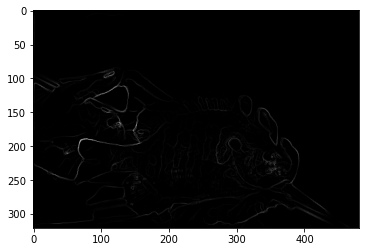

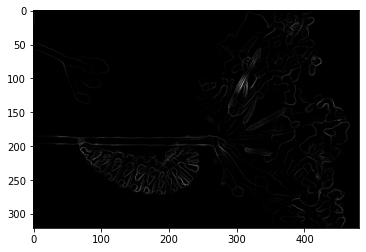

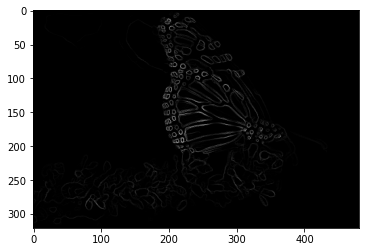

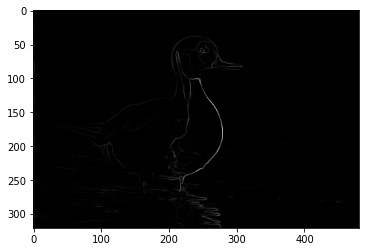

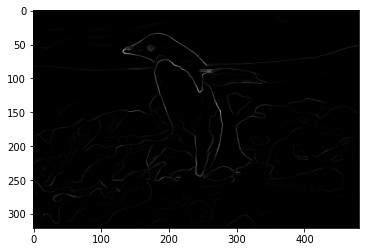

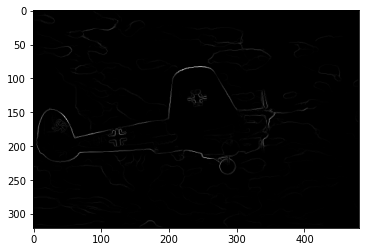

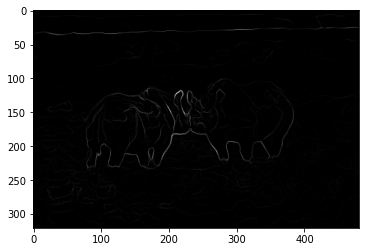

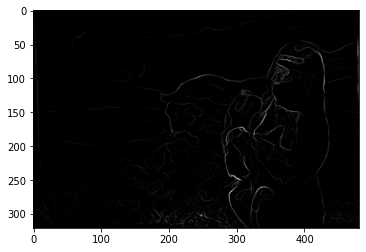

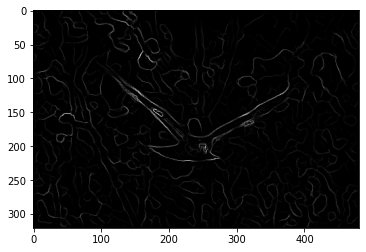

In [ ]:
pb_edege_out=[]
for i in range(len(image_list)):	
  pb_edge =final_edge(texton_grad[i], brightness_grad[i], colour_grad[i], canny_baseline[i], sobel_baseline[i], [0.5,0.5])
  pb_edege_out.append(pb_edge)
  plt.imshow(pb_edge, cmap = "gray")
  plt.show()
